# this is all on a single fiber still

In [244]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [245]:
import numpy as np

from astropy.io import fits
from astropy.stats import biweight_location
from sklearn.decomposition import PCA
import pickle
from matplotlib import pyplot as plt
% matplotlib inline
from collections import OrderedDict

import spectrum

In [3]:
def load_skys(ff,which="sky_spectrum"):
    skys = OrderedDict()
    shotids = OrderedDict()
    N = len(ff)
    sff = []
    for i,f in enumerate(ff):
        if i % 100 == 0:
            print("loading {} out of {}.".format(i,N))
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        try:
            ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
            skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"] 
            shotids[(shotid,exp)] = f
        except:
            print("Error loading {}.".format(f))
            pass
    print("starting wl = ", ww[0], "A")
    return ww, skys, sff

In [4]:
fn_shotlist_pca = "shotlist_pca.txt"
IFU = "022"

with open(fn_shotlist_pca, 'r') as f:
    s = f.read()
shotlist_PCA = s.split()


In [9]:
ff_LL=[]
for shot in shotlist_PCA:
    if shot.startswith("#"):
        continue
    cmd = "ls ../rebin/{}/exp0?/multi_???_{}_???_LL_rebin.pickle".format(shot, IFU)
    tmp = !$cmd
    ff_LL += tmp

In [ ]:
skys = OrderedDict()
ww,skys[(IFU,"LL")],sff = load_skys(ff_LL,which="sky_spectrum")

loading 0 out of 366.


/afs/ipp-garching.mpg.de/home/m/mxhf/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [8]:
XA = np.array( [ biweight_location( skys[(IFU,"LL")][k], axis=0 )  for k in skys[(IFU,"LL")] ] )
# reconstruct the sky in fiber B, (here fiber 75 in 022,LL).
fiber = 75
XB = np.array( [skys[(IFU,"LL")][k][fiber] for k in skys[(IFU,"LL")] ] )

KeyError: ('022', 'LL')

In [215]:
# hack to homogenize lengths, the rebinning does make sure
# that the wavelength grid always stars at the same wavelength
# but not necessarey, end at the same ( ther may be a few pixel more or less)
N = np.min([XA.shape[1], XB.shape[1], ww.shape[0]])
ww = ww[:N]
XA = XA[:,:N]
XB = XB[:,:N]
# selct wavelength subrange
#wstart = 4626.668686
#wend  = 5400.
wstart = 3495.
wend = 5493.
wend = 5454.76 # masking out one bad feature at the red end

#ww = 
ii = (ww >= wstart) * (ww <= wend)

wwcut = ww[ii]
XAcut = XA[:,ii]
XBcut = XB[:,ii]

In [216]:
XAcut.shape

np.std(XAcut)

4420.833697147562

300 of 366 survive cut.


Text(0,0.5,'N')

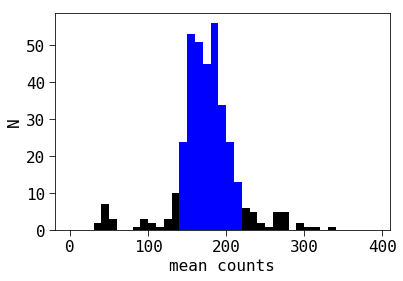

In [217]:
#mm = np.mean( XAcut[:,125:225], axis=1)
mm = np.mean( XAcut[:,450:600], axis=1)

plt.hist(mm,bins=np.arange(0,400,10))


start, stop = 140., 220.
jj = (mm > start) * (mm < stop)

plt.hist(mm[jj],bins=np.arange(0,400,10))

print("{} of {} survive cut.".format(np.sum(jj),len(jj)))
plt.xlabel("mean counts")
plt.ylabel("N")

In [218]:
kk = jj
#kk = [("20180221" not in f) for f in np.array(sff) ]

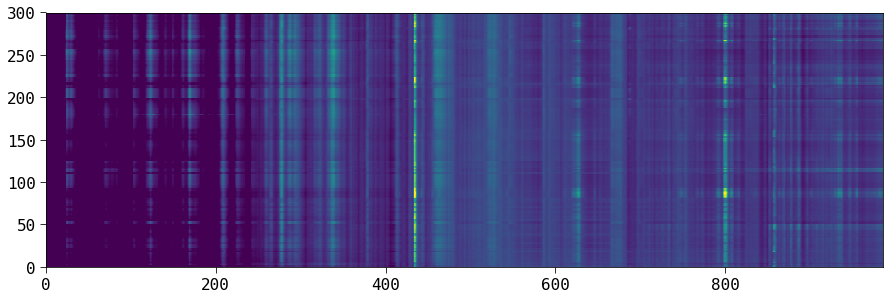

In [219]:
#% matplotlib notebook
f = plt.figure(figsize=[15,15])
#plt.imshow((XAcut.T/mm).T[jj*kk][:,275:300], vmin=.6,vmax=1.4, origin="bottom")
plt.imshow((XAcut.T/mm).T[jj*kk], vmin=.6,vmax=2.4, origin="bottom")

In [220]:
XAcut = XAcut[jj*kk]
XBcut = XBcut[jj*kk]

In [221]:
XAcut.shape

(300, 986)

In [222]:

# Add synthetic lines in every B - spectrum
# random wavelength
# random sigma (3.5 - 10. A)
# random amplitude (20 - 100. A)
if True:
    #generic gaussian
    def gauss(mu, sigma, x):
        return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))

    gg = []
    
    for i in range(XBcut.shape[0]):
        mu = np.random.uniform()* (wwcut[-1] - wwcut[0]) + wwcut[0]
        sigma = np.random.uniform() * 10. + 3.5
        A = np.random.uniform() * 90. + 50.

        g = A*gauss(mu, sigma, wwcut)

        XBcut[i]  = XBcut[i] + g
        
        gg.append(g)

In [223]:
MA = np.mean(XAcut,axis=0)
XAmean = XAcut - MA

In [224]:
MB = np.mean(XBcut,axis=0)
XBmean = XBcut - MB

In [225]:
np.std(XAmean)

20.86512476062447

[9615.34669153 5312.23316514 2208.33801113 1285.92952974  608.53338357
  533.33463398  496.99583574  340.19493356  297.65521863  258.93637473
  230.21510351  189.68516297  168.06009577  122.18271309  115.3710956
   96.90020559   95.23994264   80.60400274   72.76263981   69.28052525
   62.22864889   61.12460471   57.44081087   55.89872104   52.20185136]


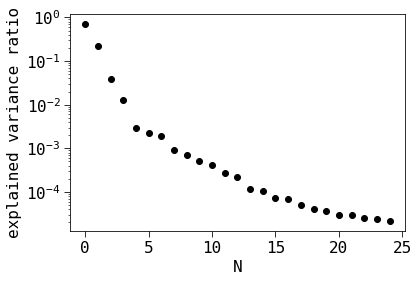

In [235]:
n_components = 25
pcaA = PCA(n_components=n_components)
pcaA.fit(XAmean)
plt.plot(pcaA.explained_variance_ratio_, 'o')  
plt.xlabel("N")
plt.ylabel("explained variance ratio")
plt.yscale('log')
print(pcaA.singular_values_) 

In [236]:
# project pca componets onto
# mean shifted input spectra
ccA = np.inner(XAmean,pcaA.components_)

# reconstruct pca comonents through linear combination
rcA = np.matmul( XAmean.T, ccA).T
# they wont be normalized yet
for i,cA in enumerate(rcA):
    rcA[i] = rcA[i]/np.linalg.norm(rcA[i])

#rc = rc/np.linalg.norm(rc,axis=1)

In [237]:
# make sure the result is the same
(np.abs( rcA - pcaA.components_) < 1e-6).all()

False

In [238]:
# compute projection of input spectra onto PCA basis
tA = pcaA.transform(XAmean)

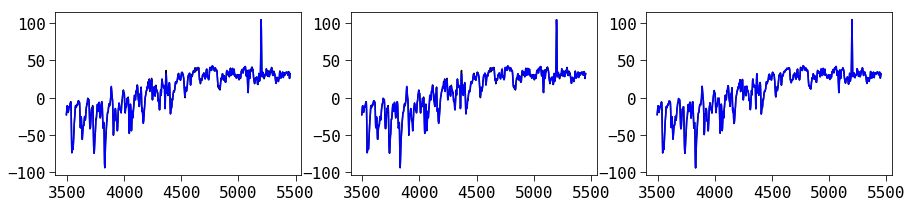

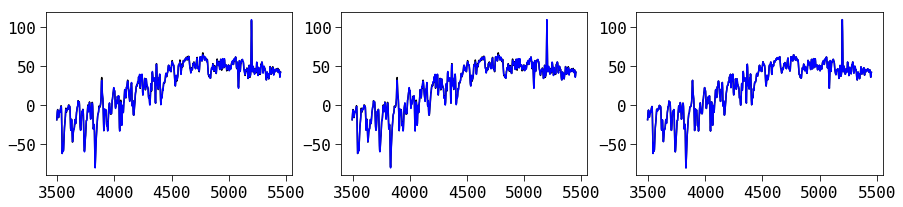

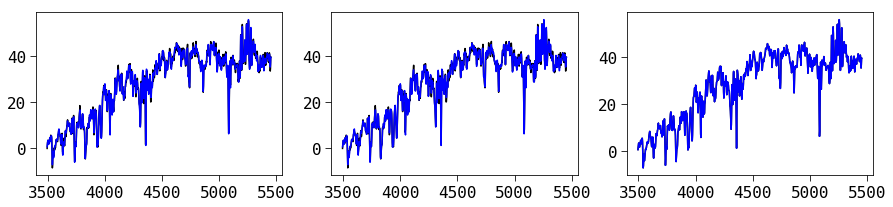

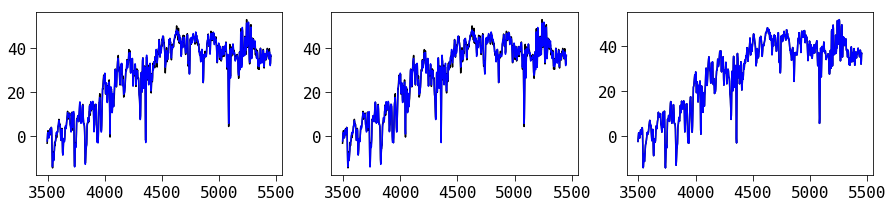

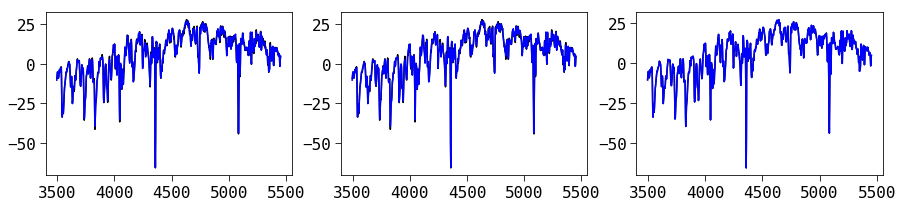

In [239]:
# make sure we can reconstruct the spectra from the
# actual principal components but also from the reconstructed ones
for i in range(5):
    f = plt.figure(figsize=[15,3])
    # plotting input mean spectra and
    # direct reconstruction from PCA
    plt.subplot(131)
    plt.plot( wwcut, XAmean[i] )
    # next two lines must have identical result
    plt.plot( wwcut, np.inner(tA, pcaA.components_.T)[i] )
    #plt.plot( wwcut, pcaA.inverse_transform(tA)[i] )


    plt.subplot(132)
    # plotting input mean spectra and
    #  reconstruction from rebuilt PCA components
    plt.plot( wwcut, XAmean[i] )
    plt.plot( wwcut, np.inner(tA, rcA.T)[i] )


    plt.subplot(133)
    # plot
    # direct reconstruction from PCA
    # and reconstruction from rebuilt PCA components
    # (but not input spectra)
    plt.plot( wwcut, np.inner(tA, pcaA.components_.T)[i] )
    plt.plot( wwcut, np.inner(tA, rcA.T)[i] )


In [240]:
# reconstruct pca components of B through linear combination of spectra from B
# BUT using projection from A
rcB = np.matmul( XBmean.T, ccA).T
# they wont be normalized yet
for i,cB in enumerate(rcB):
    rcB[i] = rcB[i]/np.linalg.norm(rcB[i])

/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


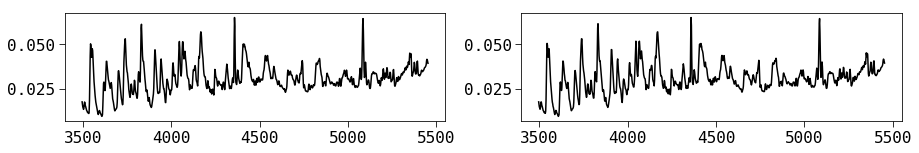

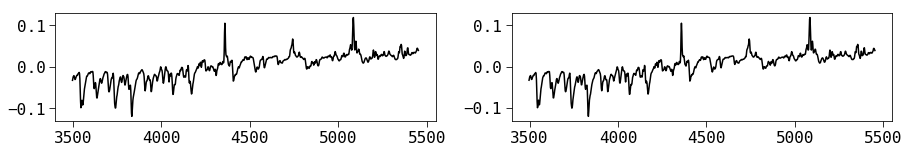

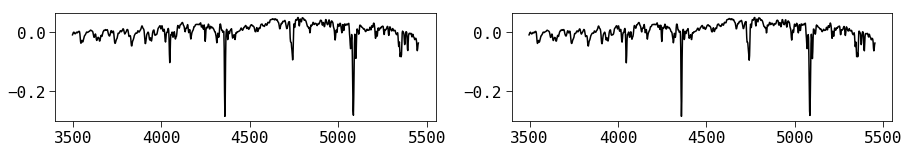

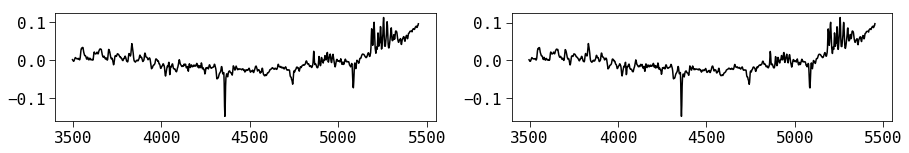

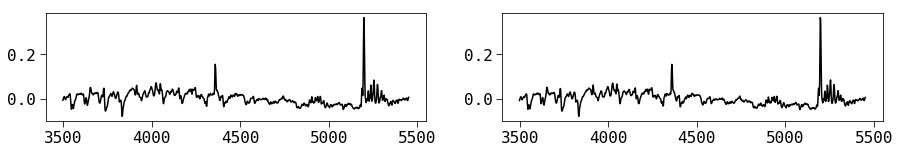

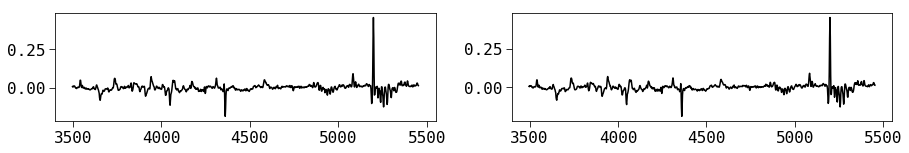

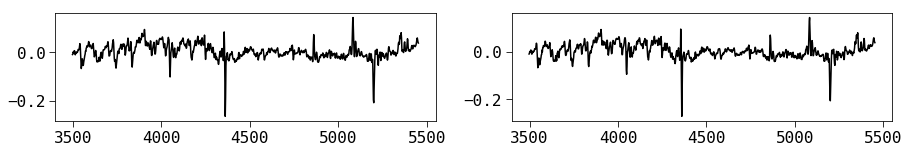

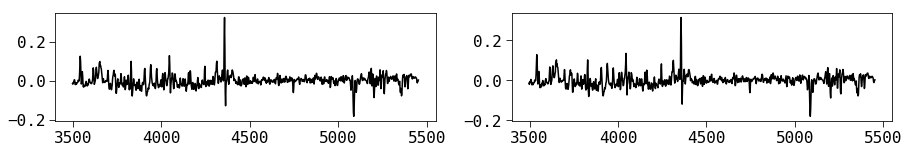

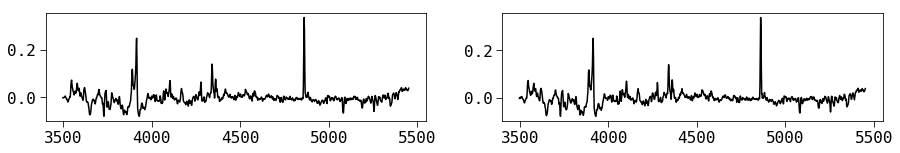

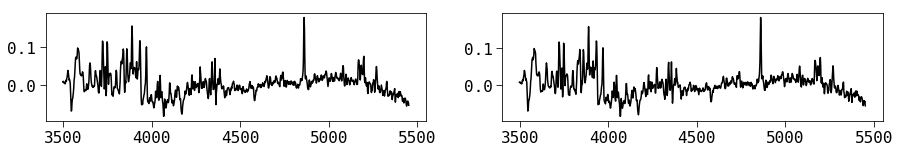

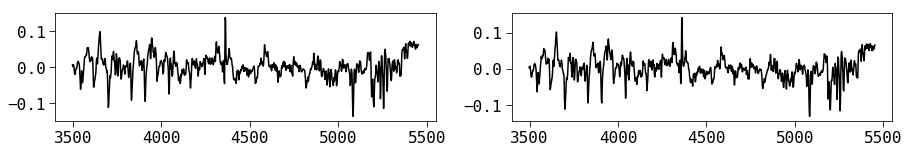

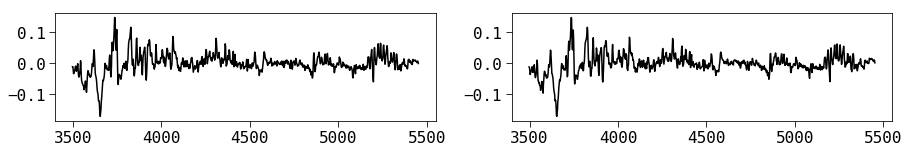

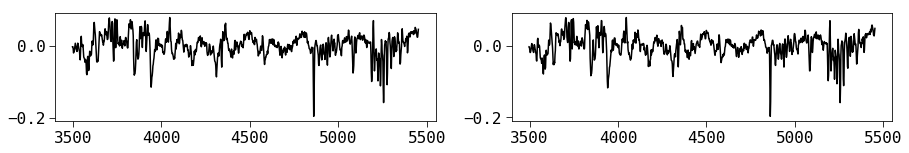

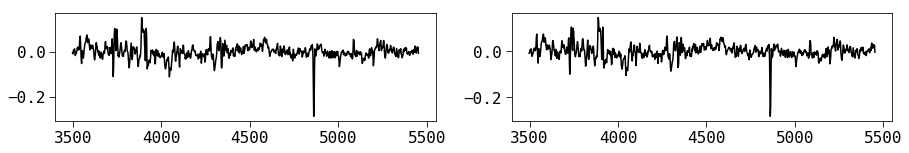

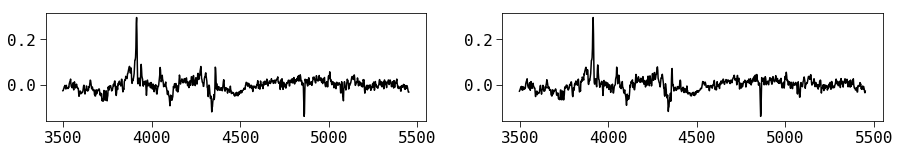

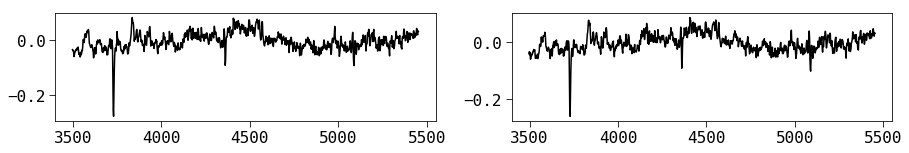

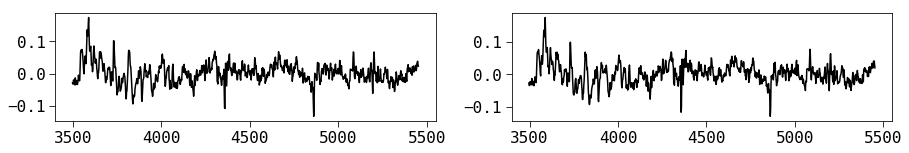

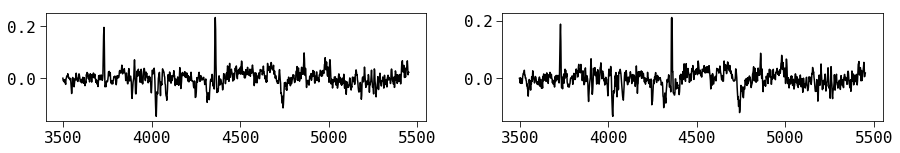

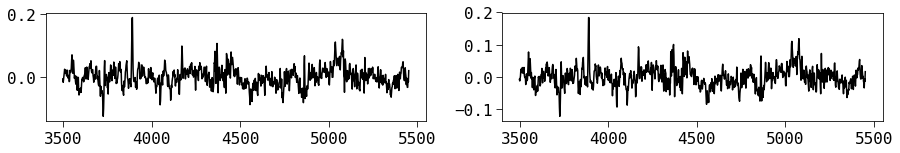

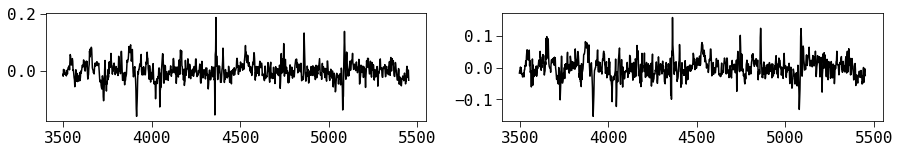

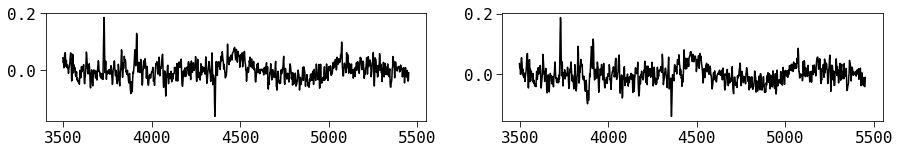

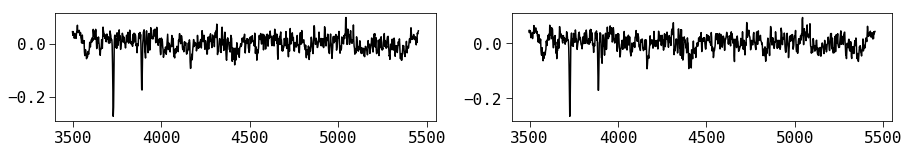

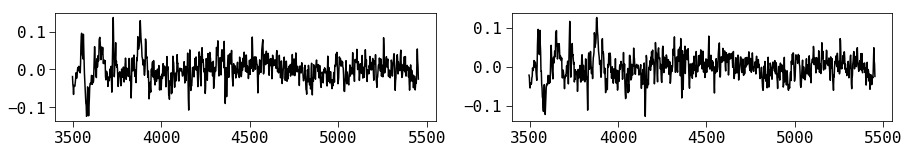

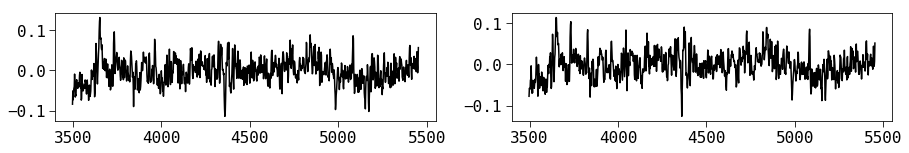

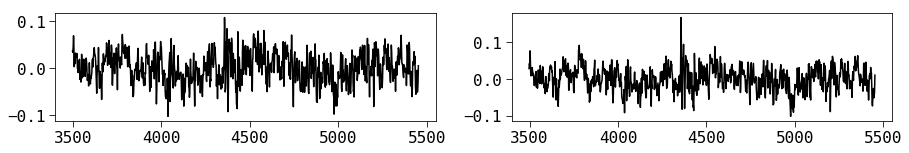

In [241]:
# plot PCA components for A and B
for i in range(pcaA.n_components):
    f = plt.figure(figsize=[15,2])
    plt.subplot(121)
    plt.plot( wwcut, pcaA.components_[i] )
    plt.subplot(122)
    plt.plot( wwcut, rcB[i] )    

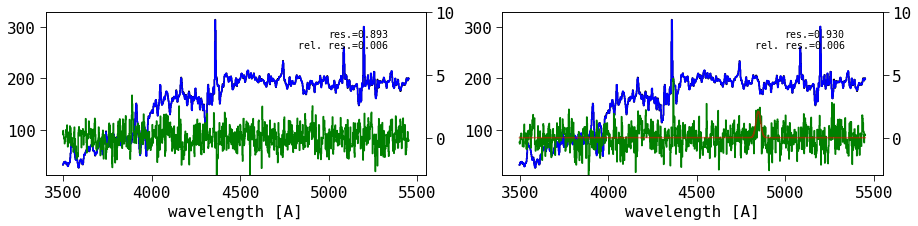

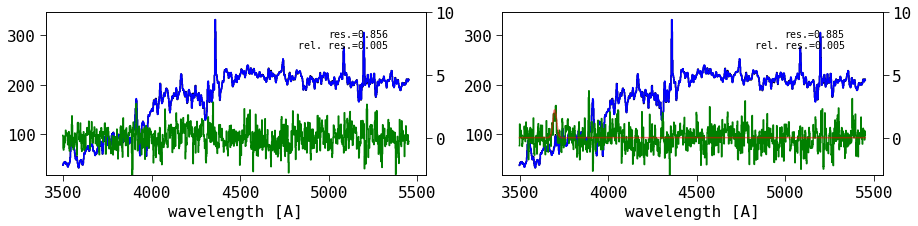

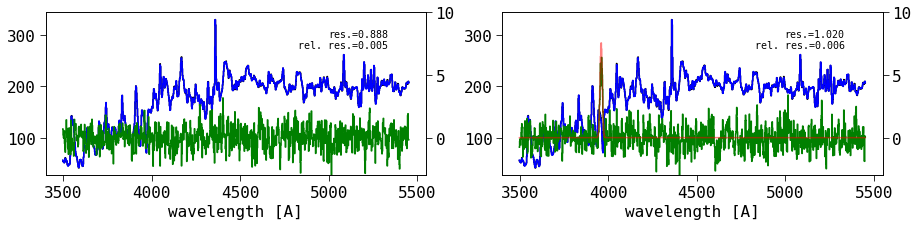

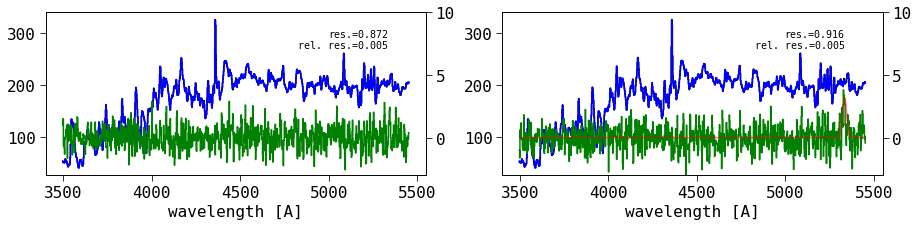

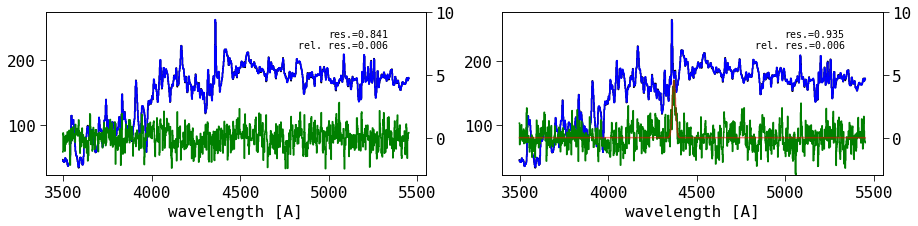

In [242]:
# Finally, check how well we are doing:
# Make sure we can reconstuct the spectra from the
# actual principal components for A but also from the reconstructed ones for B
for i in range(5):
    f = plt.figure(figsize=[15,3])
    ax = plt.subplot(121)
    
    y  = XAmean[i] + MA
    ry = np.inner(tA, pcaA.components_.T)[i] + MA
    res = ry-y
    plt.plot(wwcut,  y , drawstyle='steps-mid' )
    plt.plot(wwcut, ry , drawstyle='steps-mid' )
    plt.xlabel("wavelength [A]")
    plt.twinx()
    plt.plot(wwcut,   res, 'g-' , drawstyle='steps-mid' )
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
    
    

    ax = plt.subplot(122, sharex=ax)
    
    y  = XBmean[i] + MB
    ry = np.inner(tA, rcB.T)[i] + MB
    res = y-ry
    
    plt.plot(wwcut,   y , drawstyle='steps-mid' )
    plt.plot(wwcut,   ry , drawstyle='steps-mid' )
    plt.xlabel("wavelength [A]")
    plt.twinx()
    
    plt.plot(wwcut,   res, 'g-' , drawstyle='steps-mid')
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')


    plt.plot(wwcut,   gg[i], 'r-' , drawstyle='steps-mid', alpha=.5)


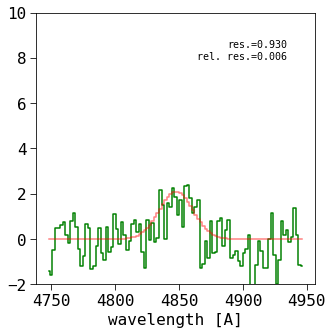

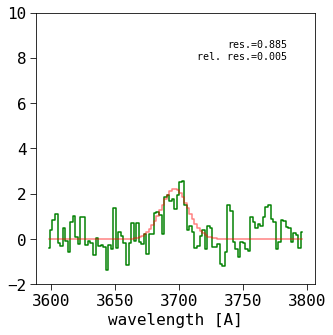

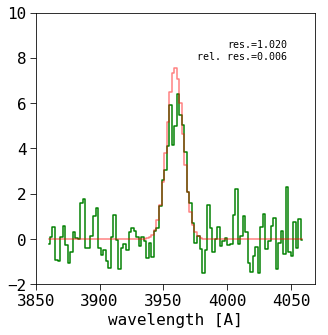

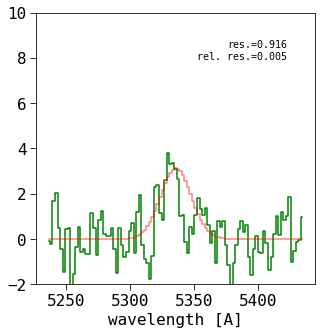

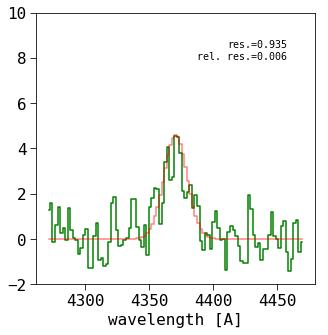

In [243]:
# Finally, check how well we are doing:
# Make sure we can reconstuct the spectra from the
# actual principal components for A but also from the reconstructed ones for B
for i in range(5):
    f = plt.figure(figsize=[5,5])
    ax = plt.subplot()
    y  = XBmean[i] + MB
    ry = np.inner(tA, rcB.T)[i] + MB
    res = y-ry

    wc = wwcut[np.argmax(gg[i])]
    ii = (wwcut > (wc-100.)) * (wwcut < (wc+100.))

    plt.plot(wwcut[ii],   res[ii], 'g-' , drawstyle='steps-mid')
    plt.ylim([-2,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')

    plt.plot(wwcut[ii],   gg[i][ii], 'r-' , drawstyle='steps-mid', alpha=.5)

    plt.xlabel("wavelength [A]")